In [1]:

!git clone https://github.com/MarsImmortal/neural_factorization_machine.git


Cloning into 'neural_factorization_machine'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 141 (delta 62), reused 95 (delta 40), pack-reused 24 (from 1)
Receiving objects: 100% (141/141), 20.09 MiB | 6.04 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Updating files: 100% (15/15), done.


In [2]:
%cd neural_factorization_machine

/content/neural_factorization_machine


In [24]:
import numpy as np
import os

class LoadData(object):
    '''given the path of data, return the data format for DeepFM
    :param path
    return:
    Train_data: a dictionary, 'Y' refers to a list of y values; 'X' refers to a list of features_M dimension vectors with 0 or 1 entries
    Test_data: same as Train_data
    Validation_data: same as Train_data
    '''

    def __init__(self, path, dataset, loss_type):
        self.path = path + dataset + "/"
        self.trainfile = self.path + dataset +".train.libfm"
        self.testfile = self.path + dataset + ".test.libfm"
        self.validationfile = self.path + dataset + ".validation.libfm"
        self.features_M = self.map_features()
        self.Train_data, self.Validation_data, self.Test_data = self.construct_data(loss_type)

    def map_features(self):
        self.features = {}
        self.read_features(self.trainfile)
        self.read_features(self.testfile)
        self.read_features(self.validationfile)
        return len(self.features)

    def read_features(self, file):
        with open(file) as f:
            line = f.readline()
            i = len(self.features)
            while line:
                items = line.strip().split(' ')
                for item in items[1:]:
                    if item not in self.features:
                        self.features[item] = i
                        i += 1
                line = f.readline()

    def construct_data(self, loss_type):
        X_, Y_, Y_for_logloss = self.read_data(self.trainfile)
        Train_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        X_, Y_, Y_for_logloss = self.read_data(self.validationfile)
        Validation_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        X_, Y_, Y_for_logloss = self.read_data(self.testfile)
        Test_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        return Train_data, Validation_data, Test_data

    def read_data(self, file):
        X_ = []
        Y_ = []
        Y_for_logloss = []
        with open(file) as f:
            line = f.readline()
            while line:
                items = line.strip().split(' ')
                Y_.append(float(items[0]))
                v = 1.0 if float(items[0]) > 0 else 0.0
                Y_for_logloss.append(v)
                X_.append([self.features[item] for item in items[1:]])
                line = f.readline()
        return X_, Y_, Y_for_logloss

    def construct_dataset(self, X_, Y_):
        Data_Dic = {}
        X_lens = [len(line) for line in X_]
        indexs = np.argsort(X_lens)
        Data_Dic['Y'] = [Y_[i] for i in indexs]
        Data_Dic['X'] = [X_[i] for i in indexs]
        return Data_Dic

    def truncate_features(self):
        num_variable = len(self.Train_data['X'][0])
        for i in range(len(self.Train_data['X'])):
            num_variable = min(num_variable, len(self.Train_data['X'][i]))
        for i in range(len(self.Train_data['X'])):
            self.Train_data['X'][i] = self.Train_data['X'][i][:num_variable]
        for i in range(len(self.Validation_data['X'])):
            self.Validation_data['X'][i] = self.Validation_data['X'][i][:num_variable]
        for i in range(len(self.Test_data['X'])):
            self.Test_data['X'][i] = self.Test_data['X'][i][:num_variable]
        return num_variable


In [26]:
import tensorflow as tf
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, loss_type='square_loss', activation='relu'):
        super(NeuralFM, self).__init__()
        self.embedding = tf.keras.layers.Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = []
        for layer_size in layers:
            self.hidden_layers.append(tf.keras.layers.Dense(layer_size, activation=activation))
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid' if loss_type == 'log_loss' else 'linear')
        self.dropout_layers = [tf.keras.layers.Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output


Num GPUs Available:  1
Physical devices cannot be modified after being initialized
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.6469 - val_loss: 0.3650
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3380 - val_loss: 0.3223
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2986 - val_loss: 0.2919
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2666 - val_loss: 0.2650
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2370 - val_loss: 0.2451
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2100 - val_loss: 0.2345
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1896 - val_loss: 0.2219
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1703 - val_loss: 0.2148
Epoch 9/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1535 - val_loss: 0.2064
Epoch 10/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1400 - val_loss: 0.2021
Epoch 11/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1278 - val_loss: 0.1977
Epoch 12/200
1579/1579 ━━━━━━

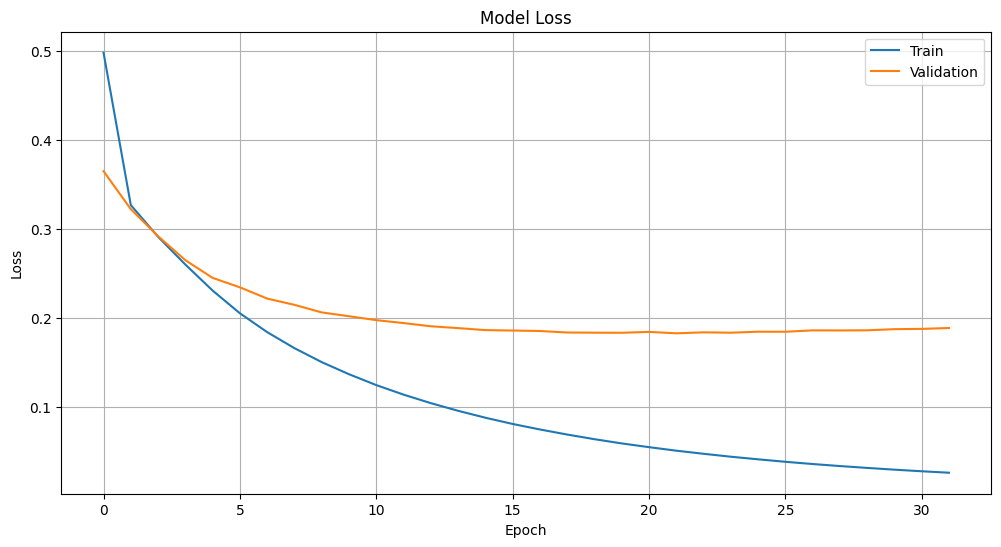

In [11]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import mean_squared_error, log_loss
import numpy as np
from tensorflow.keras import mixed_precision

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Allow memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load data
path = 'data/'
dataset = 'frappe'
loss_type = 'square_loss'  # or 'log_loss'

# Initialize data loader
loader = LoadData(path, dataset, loss_type)
feature_dim = loader.features_M
hidden_factor = 64
layers = [64]
keep_prob = [0.8, 0.5]

# Create model
model = NeuralFM(
    feature_dim=feature_dim,
    hidden_factor=hidden_factor,
    layers=layers,
    keep_prob=keep_prob,
    loss_type=loss_type,
    activation='relu'
)

# Compile model
optimizer = Adagrad(learning_rate=0.05)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy' if loss_type == 'log_loss' else 'mean_squared_error'
)

# Prepare data
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)  # Adjust buffer size if necessary
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

# Create datasets with batch size
batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Define early stopping and TensorBoard callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

# Train model with callbacks
history = model.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save the trained model in Keras format
model.save('neural_fm_model.keras')
print("Model saved to neural_fm_model.keras")

# Evaluate model
y_pred = model.predict(test_dataset)
if loss_type == 'log_loss':
    score = log_loss(y_test, y_pred)
else:
    score = mean_squared_error(y_test, y_pred)

print(f"Test {loss_type} score: {score}")

# Plot training & validation loss values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4972 - loss: 0.7186 - val_accuracy: 0.4250 - val_loss: 0.7150
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5038 - loss: 0.7009 - val_accuracy: 0.4250 - val_loss: 0.7074
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5263 - loss: 0.6960 - val_accuracy: 0.4750 - val_loss: 0.7007
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5034 - loss: 0.6917 - val_accuracy: 0.4300 - val_loss: 0.7175

Training History:
Epochs: 4
Training Losses: [0.7124733924865723, 0.6983382701873779, 0.6966876983642578, 0.6921339631080627]
Validation Losses: [0.7150099277496338, 0.7073748707771301, 0.7006969451904297, 0.7175426483154297]
Training Accuracies: [0.5019999742507935, 0.4970000088214874, 0.515999972820282, 0.503000020980835]
Validation Accuracies: [0.42500001192092896, 0.42500001192092896, 0.4749999940395355, 0.4300000071525574]
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4876 - loss: 0.7017 
Eval

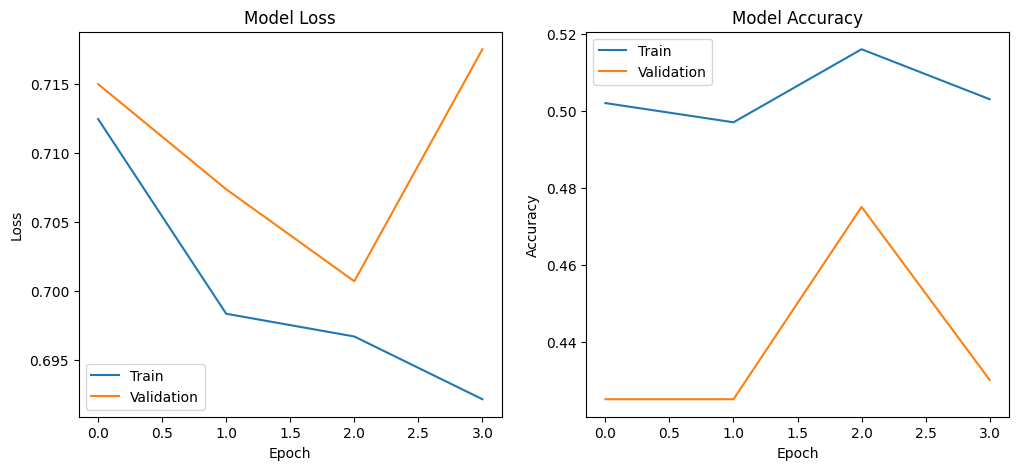

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

class NeuralFM(Model):
    def __init__(self, hidden_factor=64, layers=[64], **kwargs):
        super(NeuralFM, self).__init__(**kwargs)
        self.hidden_factor = hidden_factor
        self.dense_layers = [Dense(layer_size, activation='relu') for layer_size in layers]
        self.dropout_layers = [Dropout(0.5) for _ in layers]  # Adjust dropout rates if needed
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = inputs
        for dense_layer, dropout_layer in zip(self.dense_layers, self.dropout_layers):
            x = dense_layer(x)
            if training:
                x = dropout_layer(x)
        return self.output_layer(x)

# Define your input shape based on your dataset
input_shape = (10,)  # Example shape for 2D input data
inputs = Input(shape=input_shape)
model = NeuralFM(hidden_factor=64, layers=[64])
outputs = model(inputs)
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define a smaller dataset for quick experimentation
def create_small_dataset(data, batch_size=32):
    # Use a subset of the data
    subset_size = min(len(data[0]), 1000)  # Use a maximum of 1000 samples
    small_data = (data[0][:subset_size], data[1][:subset_size])
    dataset = tf.data.Dataset.from_tensor_slices(small_data)
    dataset = dataset.shuffle(buffer_size=500).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Example train_data and validation_data should be numpy arrays or similar structures
train_data = (np.random.rand(1000, 10), np.random.randint(0, 2, size=(1000,)))
validation_data = (np.random.rand(200, 10), np.random.randint(0, 2, size=(200,)))

# Create datasets
train_dataset = create_small_dataset(train_data)
validation_dataset = create_small_dataset(validation_data)

# Callbacks for monitoring
callbacks = [
    EarlyStopping(monitor='val_loss', patience=1)  # Reduced patience for quicker experiments
]

# Train the model
history = model.fit(train_dataset,
                    epochs=5,  # Reduced number of epochs for quick feedback
                    validation_data=validation_dataset,
                    callbacks=callbacks,
                    verbose=1)

# Print training history
print("\nTraining History:")
print("Epochs:", len(history.epoch))
print("Training Losses:", history.history['loss'])
print("Validation Losses:", history.history['val_loss'])
print("Training Accuracies:", history.history['accuracy'])
print("Validation Accuracies:", history.history['val_accuracy'])

# Example test_data should be a numpy array or similar structure
test_data = (np.random.rand(200, 10), np.random.randint(0, 2, size=(200,)))

# Create test dataset
test_dataset = create_small_dataset(test_data)

# Evaluate the model on a small subset
evaluation_results = model.evaluate(test_dataset, verbose=1)

print("Evaluation Results:")
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

# Plotting training and validation metrics
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    plt.show()

# Plotting the performance
plot_history(history)


KeyError: 'loss'

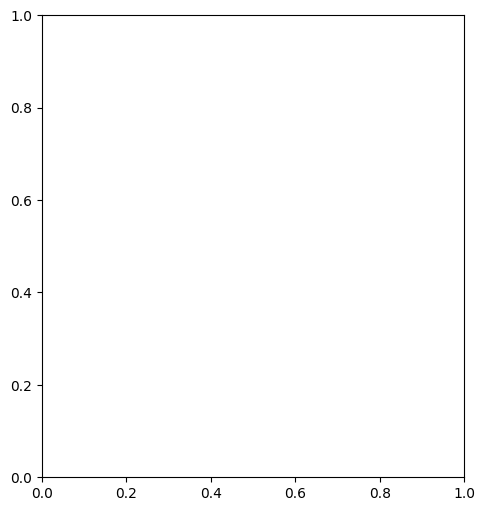

In [27]:
import matplotlib.pyplot as plt

# Assuming you have the training history saved
history = model.history  # Replace this with the actual history object you have

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot training & validation accuracy values (for classification problems)
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

plt.show()


In [12]:
!git status


On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	logs/
	neural_fm_model.keras

nothing added to commit but untracked files present (use "git add" to track)


In [16]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import os

# Define paths
model_path = 'neural_fm_model.keras'
tflite_model_path = 'neural_fm_model.tflite'

# Load the saved model
loaded_model = tf.keras.models.load_model(model_path)
print("Model loaded from", model_path)

# Prepare new or existing data for predictions
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

# Example: Assuming `loader` is an instance of LoadData and we have new data for predictions
X_new, _ = prepare_data(loader.Test_data)  # Replace with actual new data

# Make predictions with the loaded model
predictions = loaded_model.predict(X_new)
print("Predictions made")

# Evaluate the model on test data
X_test, y_test = prepare_data(loader.Test_data)  # Assuming test data is available
test_loss = loaded_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Fine-tune or continue training the model
def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)  # Adjust buffer size if necessary
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = create_dataset(X_train, y_train, batch_size=128)
val_dataset = create_dataset(X_val, y_val, batch_size=128, shuffle=False)

# Continue training the model (Example with additional epochs)
additional_epochs = 10
history = loaded_model.fit(
    train_dataset,
    epochs=additional_epochs,
    validation_data=val_dataset,
    verbose=1
)
print("Model fine-tuned")

# Export the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save TensorFlow Lite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print("Model saved to TensorFlow Lite format:", tflite_model_path)

# Optionally, you can inspect model architecture and weights
print("Model summary:")
loaded_model.summary()

weights = loaded_model.get_weights()
print("Model weights retrieved")



TypeError: Could not locate class 'NeuralFM'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'NeuralFM', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'mixed_float16'}, 'registered_name': None}}, 'registered_name': 'NeuralFM', 'build_config': {'input_shape': [None, 10]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adagrad', 'config': {'name': 'adagrad', 'learning_rate': 0.05000000074505806, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'initial_accumulator_value': 0.1, 'epsilon': 1e-07}, 'registered_name': None}, 'loss': 'mean_squared_error', 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}

In [22]:
import tensorflow as tf
from tensorflow.keras import layers

class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers_sizes, keep_prob, loss_type='square_loss', activation='relu', **kwargs):
        super(NeuralFM, self).__init__(**kwargs)
        self.feature_dim = feature_dim
        self.hidden_factor = hidden_factor
        self.layers_sizes = layers_sizes
        self.keep_prob = keep_prob
        self.loss_type = loss_type
        self.activation = activation

        self.embedding = layers.Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = [layers.Dense(size, activation=activation) for size in layers_sizes]
        self.output_layer = layers.Dense(1, activation='sigmoid' if loss_type == 'log_loss' else 'linear')
        self.dropout_layers = [layers.Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output

    def get_config(self):
        config = super(NeuralFM, self).get_config()
        config.update({
            'feature_dim': self.feature_dim,
            'hidden_factor': self.hidden_factor,
            'layers_sizes': self.layers_sizes,
            'keep_prob': self.keep_prob,
            'loss_type': self.loss_type,
            'activation': self.activation
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Ensure all expected arguments are present
        return cls(
            feature_dim=config['feature_dim'],
            hidden_factor=config['hidden_factor'],
            layers_sizes=config['layers_sizes'],
            keep_prob=config['keep_prob'],
            loss_type=config['loss_type'],
            activation=config['activation']
        )


In [23]:
import tensorflow as tf
import numpy as np

# Define paths
model_path = 'neural_fm_model.keras'
data_path = 'data/frappe/frappe.test.libfm'

# Load the saved model
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'NeuralFM': NeuralFM})
print("Model loaded from", model_path)

# Define a LoadData class if not already defined
class LoadData(object):
    def __init__(self, path, dataset):
        self.path = path
        self.dataset = dataset
        self.features_M = self.map_features()
        self.Test_data = self.construct_data()

    def map_features(self):
        self.features = {}
        self.read_features(self.path)
        return len(self.features)

    def read_features(self, file):
        with open(file) as f:
            line = f.readline()
            i = len(self.features)
            while line:
                items = line.strip().split(' ')
                for item in items[1:]:
                    if item not in self.features:
                        self.features[item] = i
                        i += 1
                line = f.readline()

    def construct_data(self):
        X_, Y_, _ = self.read_data(self.path)
        return self.construct_dataset(X_, Y_)

    def read_data(self, file):
        X_ = []
        Y_ = []
        with open(file) as f:
            line = f.readline()
            while line:
                items = line.strip().split(' ')
                Y_.append(float(items[0]))
                X_.append([self.features[item] for item in items[1:]])
                line = f.readline()
        return X_, Y_

    def construct_dataset(self, X_, Y_):
        Data_Dic = {}
        X_lens = [len(line) for line in X_]
        indexs = np.argsort(X_lens)
        Data_Dic['Y'] = [Y_[i] for i in indexs]
        Data_Dic['X'] = [X_[i] for i in indexs]
        return Data_Dic

# Initialize data loader
loader = LoadData('data/frappe/', 'frappe')

# Prepare data function
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

# Prepare test data
X_test, y_test = prepare_data(loader.Test_data)

# Evaluate the model on test data
test_loss = loaded_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

# Optionally, make predictions and inspect some results
predictions = loaded_model.predict(X_test)
print("Predictions made")

# If you want to inspect some predictions and true values
num_samples_to_show = 5
print("Sample Predictions and True Values:")
for i in range(num_samples_to_show):
    print(f"Sample {i+1} - True Value: {y_test[i]}, Prediction: {predictions[i][0]}")

# Optionally, you can inspect model architecture and weights
print("Model summary:")
loaded_model.summary()

weights = loaded_model.get_weights()
print("Model weights retrieved")


KeyError: 'feature_dim'

In [30]:
# Load the pre-trained model
model = tf.keras.models.load_model('neural_fm_model.keras')


TypeError: Could not locate class 'NeuralFM'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'NeuralFM', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'mixed_float16'}, 'registered_name': None}}, 'registered_name': 'NeuralFM', 'build_config': {'input_shape': [None, 10]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adagrad', 'config': {'name': 'adagrad', 'learning_rate': 0.05000000074505806, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'initial_accumulator_value': 0.1, 'epsilon': 1e-07}, 'registered_name': None}, 'loss': 'mean_squared_error', 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}

In [31]:
model = tf.keras.models.load_model('neural_fm_model.keras', custom_objects={'NeuralFM': NeuralFM})


TypeError: <class '__main__.NeuralFM'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'NeuralFM', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'mixed_float16'}, 'registered_name': None}}, 'registered_name': 'NeuralFM', 'build_config': {'input_shape': [None, 10]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adagrad', 'config': {'name': 'adagrad', 'learning_rate': 0.05000000074505806, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'initial_accumulator_value': 0.1, 'epsilon': 1e-07}, 'registered_name': None}, 'loss': 'mean_squared_error', 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class '__main__.NeuralFM'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of NeuralFM from its config.

Received config={'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'mixed_float16'}, 'registered_name': None}}

Error encountered during deserialization: NeuralFM.__init__() got an unexpected keyword argument 'trainable'

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout

# Register your custom model class
@tf.keras.utils.register_keras_serializable()
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, loss_type='square_loss', activation='relu'):
        super(NeuralFM, self).__init__()
        self.embedding = Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = []
        for layer_size in layers:
            self.hidden_layers.append(Dense(layer_size, activation=activation))
        self.output_layer = Dense(1, activation='sigmoid' if loss_type == 'log_loss' else 'linear')
        self.dropout_layers = [Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output


In [34]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, log_loss
import numpy as np

# Load the pre-trained model
model = load_model('neural_fm_model.keras', custom_objects={'NeuralFM': NeuralFM})

# Prepare the test data
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

def create_dataset(X, y, batch_size=128, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)  # Adjust buffer size if necessary
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare data
X_test, y_test = prepare_data(loader.Test_data)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Evaluate the model
y_pred = model.predict(test_dataset)
y_pred = np.squeeze(y_pred)  # Remove single-dimensional entries

if loss_type == 'log_loss':
    score = log_loss(y_test, y_pred)
else:
    score = mean_squared_error(y_test, y_pred)

print(f"Test {loss_type} score: {score}")

# Plot training & validation loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


TypeError: <class '__main__.NeuralFM'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'NeuralFM', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'mixed_float16'}, 'registered_name': None}}, 'registered_name': 'NeuralFM', 'build_config': {'input_shape': [None, 10]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adagrad', 'config': {'name': 'adagrad', 'learning_rate': 0.05000000074505806, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'initial_accumulator_value': 0.1, 'epsilon': 1e-07}, 'registered_name': None}, 'loss': 'mean_squared_error', 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class '__main__.NeuralFM'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of NeuralFM from its config.

Received config={'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'mixed_float16'}, 'registered_name': None}}

Error encountered during deserialization: NeuralFM.__init__() got an unexpected keyword argument 'trainable'